In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

# training properties
DEBUG = False
SEED = 42
BATCH_SIZE = 64
EPOCHS = 3 if DEBUG else 100000
DATA_DIR = 'drive/MyDrive/data_telur/dataset/'
INPUT_SHAPE = (224, 224, 3)

In [ ]:
import tensorflow as tf

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255.0,
    validation_split = 0.2
)

train_generator = datagen.flow_from_directory(
    DATA_DIR,
    batch_size = BATCH_SIZE,
    seed = SEED,
    target_size=(224, 224),
    class_mode = 'binary',
    subset = 'training'
)

validation_generator = datagen.flow_from_directory(
    DATA_DIR,
    shuffle=False,
    batch_size = BATCH_SIZE,
    seed = SEED,
    target_size=(224, 224),
    class_mode = 'binary',
    subset = 'validation'
)

Found 8112 images belonging to 2 classes.
Found 2026 images belonging to 2 classes.


In [ ]:
class_names = train_generator.class_indices

class_df = pd.DataFrame.from_dict(class_names, orient='index', columns=['id'])

class_df.to_csv('classes.csv')
class_df.head()

,id
fertil,0
infertil,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


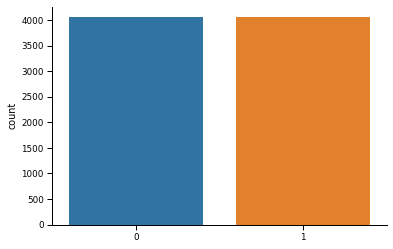

In [ ]:
sns.countplot(train_generator.classes)
sns.set_context('paper')
sns.despine()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


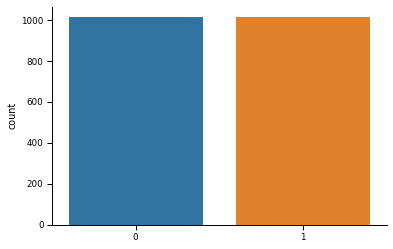

In [ ]:
sns.countplot(validation_generator.classes)
sns.set_context('paper')
sns.despine()

Terlihat jelas bahwa distribusi class dalam dataset sudah seimbang sehingga tidak dibutuhkannya preprocessing maupun regularisasi terlebih lanjut

In [ ]:
model1 = tf.keras.applications.MobileNetV2(include_top=False, input_shape=INPUT_SHAPE)
model1.trainable = False


input_layer1 = tf.keras.Input(shape=INPUT_SHAPE)

model_layers1 = model1(input_layer1)
model_layers1 = tf.keras.layers.Flatten()(model_layers1)
#output_layer1 = tf.keras.layers.Dense(len(class_df), activation='softmax')(model_layers1)
output_layer1 = tf.keras.layers.Dense(1, activation='sigmoid')(model_layers1)

model1 = tf.keras.Model(input_layer1, output_layer1)

model1.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 62721     
Total params: 2,320,705
Trainable params: 62,721
Non-trainable params: 2,257,984
_________________________________________________________________


# Optimizer Adam

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', min_delta=0, patience=10, verbose=0,
      mode='auto', restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
      monitor='val_loss', factor=0.1, patience=3, verbose=0,
      mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.0001
    )
]
model1.compile(optimizer='Adam',
             loss='binary_crossentropy',
             metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

hist1 = model1.fit(
    train_generator, 
    workers=8, 
    steps_per_epoch=train_generator.samples // BATCH_SIZE, 
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=validation_generator, 
    validation_steps=validation_generator.samples // BATCH_SIZE)

Epoch 1/100000
126/126 [==============================] - 38s 255ms/step - loss: 0.2746 - accuracy: 0.9559 - precision_4: 0.9560 - recall_4: 0.9557 - val_loss: 0.2010 - val_accuracy: 0.9491 - val_precision_4: 0.9791 - val_recall_4: 0.9156
Epoch 2/100000
126/126 [==============================] - 31s 241ms/step - loss: 0.0046 - accuracy: 0.9983 - precision_4: 0.9980 - recall_4: 0.9985 - val_loss: 0.1627 - val_accuracy: 0.9602 - val_precision_4: 0.9551 - val_recall_4: 0.9640
Epoch 3/100000
126/126 [==============================] - 31s 238ms/step - loss: 4.7799e-04 - accuracy: 0.9999 - precision_4: 0.9998 - recall_4: 1.0000 - val_loss: 0.1605 - val_accuracy: 0.9592 - val_precision_4: 0.9578 - val_recall_4: 0.9588
Epoch 4/100000
126/126 [==============================] - 31s 237ms/step - loss: 1.1860e-04 - accuracy: 1.0000 - precision_4: 1.0000 - recall_4: 1.0000 - val_loss: 0.1614 - val_accuracy: 0.9587 - val_precision_4: 0.9587 - val_recall_4: 0.9567
Epoch 5/100000
126/126 [============

dict_keys(['loss', 'accuracy', 'precision_4', 'recall_4', 'val_loss', 'val_accuracy', 'val_precision_4', 'val_recall_4', 'lr'])


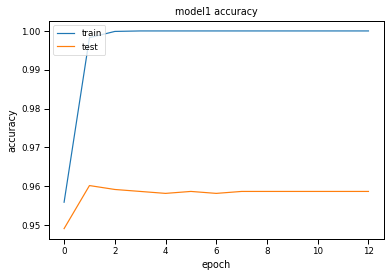

In [ ]:
import matplotlib.pyplot as plt

print(hist1.history.keys())
# summarize history for accuracy
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.title('model1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(hist1.history['precision'])
plt.plot(hist1.history['val_precision'])
plt.title('model1 precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

KeyError: ignored

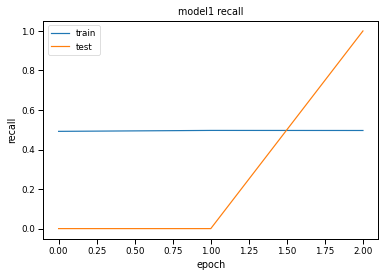

In [ ]:
plt.plot(hist1.history['recall'])
plt.plot(hist1.history['val_recall'])
plt.title('model1 recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
probas = model1.predict(validation_generator)
y_pred = np.argmax(probas, axis=1)
y_true = validation_generator.classes
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1013
           1       0.00      0.00      0.00      1013

    accuracy                           0.50      2026
   macro avg       0.25      0.50      0.33      2026
weighted avg       0.25      0.50      0.33      2026



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Optimizer SGD

In [ ]:
model1.compile(optimizer='SGD',
             loss='categorical_crossentropy',
             metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

hist1 = model1.fit(
    train_generator, 
    workers=8, 
    steps_per_epoch=train_generator.samples // BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_data=validation_generator, 
    validation_steps=validation_generator.samples // BATCH_SIZE)

Epoch 1/3
126/126 [==============================] - 51s 349ms/step - loss: 64.8533 - accuracy: 0.4922 - precision_1: 0.4922 - recall_1: 0.4922 - val_loss: 107.9090 - val_accuracy: 0.4894 - val_precision_1: 0.4894 - val_recall_1: 0.4894
Epoch 2/3
126/126 [==============================] - 43s 333ms/step - loss: 63.6507 - accuracy: 0.4959 - precision_1: 0.4959 - recall_1: 0.4959 - val_loss: 107.9580 - val_accuracy: 0.4894 - val_precision_1: 0.4894 - val_recall_1: 0.4894
Epoch 3/3
126/126 [==============================] - 43s 332ms/step - loss: 59.8979 - accuracy: 0.5087 - precision_1: 0.5087 - recall_1: 0.5087 - val_loss: 62.2284 - val_accuracy: 0.4894 - val_precision_1: 0.4894 - val_recall_1: 0.4894


dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1'])


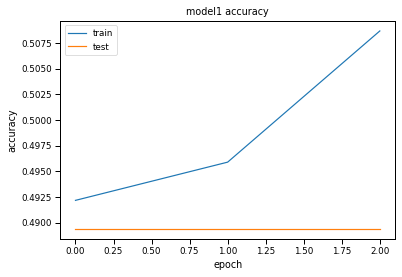

In [ ]:
import matplotlib.pyplot as plt

print(hist1.history.keys())
# summarize history for accuracy
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.title('model1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Contoh Inferensi

In [ ]:
namafile = 'test.jpg' #upload gambar menggunakan colab
image = tf.keras.preprocessing.image.load_img(namafile,target_size=(224,224))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.expand_dims(input_arr, axis=0)
input_arr_normalized = input_arr/255.0
plt.imshow(image)

In [ ]:
pred_probas = model1.predict(input_arr_normalized)
pred_probas_df = pd.DataFrame(pred_probas, index=[0], columns=class_names)
pred_probas_df